In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import re
import seaborn as sns
import time
import nltk
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Embedding, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import pad_sequences
from keras.constraints import maxnorm
from keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
from transformers import logging as hf_logging
from tqdm import tqdm 



In [2]:
df = pd.read_excel("C:/Users/jllce/Downloads/classificacao_assuntos.xlsx")

In [3]:
df.isnull().sum()

tweets    0
label     0
dtype: int64

In [4]:
# Se tiver valores nulos, usar o código abaixo

# df = df[~df['label'].isnull()]
# df

In [5]:
df1 = df["tweets"]

In [6]:
def cleanTxt(text):
  import re
  text = text.lower()
  text = re.sub(r"@([a-zA-Z0-9_]{1,50})",'',str(text)) 
  text = re.sub(r'(?:\@|https?\://)\S+','',text)
  text = re.sub(r'\d+','', text)
  text = re.sub(r"[-()\"#/;:<>{}-~=|.?,]","",text)
  return text

def removeEmojis(text):
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030"
        "]+", re.UNICODE)
  text = emoji_pattern.sub(r'', text)
  return text

def removeStopWords(text):
    stemmer = nltk.stem.RSLPStemmer()
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    words = [stemmer.stem(i) for i in text.split() if not i in stopwords]
    return (" ".join(words))


tweets_tratados = df1.apply(cleanTxt)
tweets_tratados = tweets_tratados.apply(removeEmojis)
tweets_tratados = tweets_tratados.apply(removeStopWords)

In [7]:
tweets_tratados.isnull().sum()

0

In [8]:
max_words = []
for row in tweets_tratados:
    max_words.append(len(row.split()))
print(f"The max word count is {np.asarray(max_words).max()}")

The max word count is 47


In [9]:
le = LabelEncoder()
df['label_num'] = le.fit_transform(df["label"])

label_dict = (df[['label','label_num']].drop_duplicates()
              .sort_values(by='label_num')
              .reset_index(drop=True)['label']
              .to_dict())

for index, key in label_dict.items():
    print(index, key)

0 Atendimento
1 Entrega
2 Outro
3 Produto


In [10]:
labels = pd.DataFrame(df["label_num"])
labels

,label_num
0,2
1,1
2,1
3,1
4,0
...,...
18104,2
18105,2
18106,0
18107,3


In [11]:
labels.value_counts()

label_num
2            8385
1            4819
3            2961
0            1944
dtype: int64

In [12]:
from keras.utils.np_utils import to_categorical
y = to_categorical(labels)

In [13]:
y.shape

(18109, 4)

In [14]:
# preparar tokenizer
tweets = list(tweets_tratados)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets)

In [15]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 11579 unique tokens.


In [16]:
# integer codificar os documentos
sequences = tokenizer.texts_to_sequences(tweets)

In [17]:
# preencher documentos com um comprimento máximo de 47 palavras
maxlen = np.asarray(max_words).max()
X = pad_sequences(sequences, maxlen=maxlen)

In [18]:
X.shape

(18109, 47)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12676, 47), (5433, 47), (12676, 4), (5433, 4))

In [21]:
# How is it balanced?
rounded_labels=np.argmax(y_train, axis=1)
dfrounded = pd.DataFrame(rounded_labels, columns = ['labels'])
dfrounded.value_counts()

labels
2         5865
1         3387
3         2092
0         1332
dtype: int64

In [22]:
dfrounded.value_counts(normalize=True)

labels
2         0.462685
1         0.267198
3         0.165036
0         0.105080
dtype: float64

In [28]:
# SimpleRNN
vocab_size = len(word_index) + 1
output_dim = 32
maxlen
model = Sequential()
model.add(Embedding(vocab_size, output_dim, input_length = maxlen, embeddings_constraint=maxnorm(3)))
model.add(SimpleRNN(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(output_dim))
model.add(Dense(4,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [29]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 47, 32)            370560    
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 47, 32)            2080      
                                                                 
 dropout_4 (Dropout)         (None, 47, 32)            0         
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 47, 32)            2080      
                                                                 
 dropout_5 (Dropout)         (None, 47, 32)            0         
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 4)                

In [30]:
model.save('srnn.h5')

In [31]:
# Creating a output directory to store the models weights

output_dir_rnn = './RNNSimple_outputs'
if not os.path.exists(output_dir_rnn): ### If the file directory doesn't already exists,
    os.makedirs(output_dir_rnn) ### Make it please

model_checkpoint = ModelCheckpoint(filepath=output_dir_rnn+'/weights.{epoch:02d}.hdf5',
                                  save_weights_only=True)

In [32]:
start = time.time()

# Ajustar o modelo ao conjunto de treino
rnn_hist = model.fit(X_train, y_train, epochs=10, validation_split=0.3, callbacks=[model_checkpoint])

end = time.time()

Epoch 1/10
278/278 [==============================] - 18s 48ms/step - loss: 0.9427 - accuracy: 0.6243 - val_loss: 0.7673 - val_accuracy: 0.7234
Epoch 2/10
278/278 [==============================] - 12s 45ms/step - loss: 0.6423 - accuracy: 0.7608 - val_loss: 0.6907 - val_accuracy: 0.7470
Epoch 3/10
278/278 [==============================] - 12s 45ms/step - loss: 0.5113 - accuracy: 0.8066 - val_loss: 0.6850 - val_accuracy: 0.7536
Epoch 4/10
278/278 [==============================] - 13s 46ms/step - loss: 0.4252 - accuracy: 0.8423 - val_loss: 0.7374 - val_accuracy: 0.7423
Epoch 5/10
278/278 [==============================] - 13s 45ms/step - loss: 0.3667 - accuracy: 0.8749 - val_loss: 0.7668 - val_accuracy: 0.7576
Epoch 6/10
278/278 [==============================] - 14s 49ms/step - loss: 0.3058 - accuracy: 0.9017 - val_loss: 0.8039 - val_accuracy: 0.7836
Epoch 7/10
278/278 [==============================] - 13s 47ms/step - loss: 0.2670 - accuracy: 0.9168 - val_loss: 0.8613 - val_accuracy:

NameError: name 'warnings' is not defined

Lowest Validation Loss: epoch 3
Highest Validation Accuracy: epoch 6


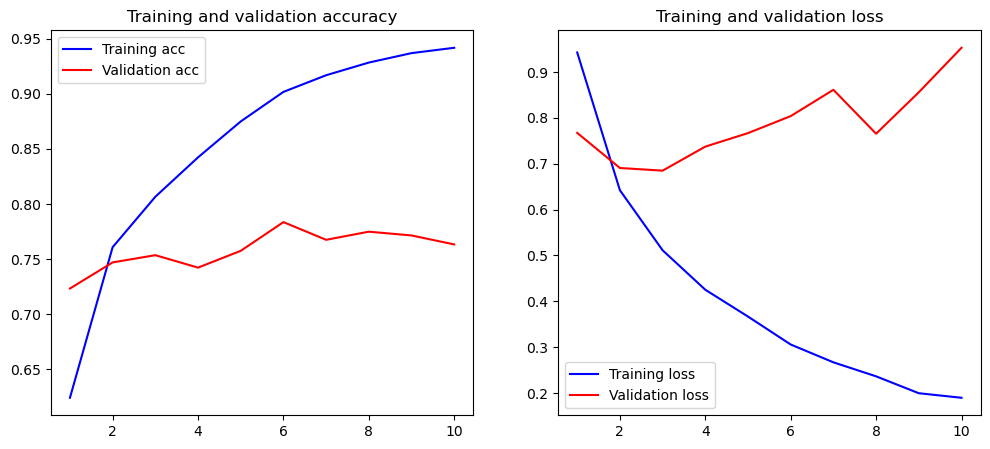

In [34]:
# SimpleRNN Result

# Plotting the training accuracy and loss
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    print("Lowest Validation Loss: epoch {}".format(np.argmin(val_loss)+1))
    print("Highest Validation Accuracy: epoch {}".format(np.argmax(val_acc)+1))

plot_history(rnn_hist)
total = (end-start)/60
print('Training duration(minutes): {}'.format(total))

In [36]:
# Loading the model with the best validation accuracy

def get_min_val_loss_epoch(history):
    return "0"+str(np.argmin(history.history['val_loss'])+1)

def get_max_val_acc_epoch(history):
    return "0"+str(np.argmax(history.history['val_accuracy'])+1)

In [37]:
epoch_num_rnn = get_max_val_acc_epoch(rnn_hist)
model.load_weights(output_dir_rnn+"/weights."+epoch_num_rnn+".hdf5") # Load in model weights

In [38]:
# Making inference on the test data
y_test_probs = model.predict(X_test)

# Turn probabilities into an interger prediction
y_hat = []
for prob in y_test_probs:
    y_hat.append(np.argmax(prob))

170/170 [==============================] - 2s 10ms/step


In [39]:
labels_4 = ['Atendimento','Entrega','Outro','Produto'] 

def print_cf(y_test, y_hat):
    cm = confusion_matrix(y_test, y_hat)
    sns.set(font_scale = 1.4, color_codes=True, palette="deep")
    sns.heatmap(pd.DataFrame(cm, index=labels_4,columns=[0,1,2,3]), 
                annot = True,
                annot_kws = {"size":16},
                fmt="d",
                cmap="YlGnBu")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Value")
    plt.xticks([0,1,2,3], labels_4, rotation=45)
    plt.ylabel("True Value")
    plt.show()

In [40]:
# Para aplicar as métricas, preciso converter do one-hot encoded para single-digit 
rounded_labels=np.argmax(y_test, axis=1)

Accuracy: 0.7853856064789251


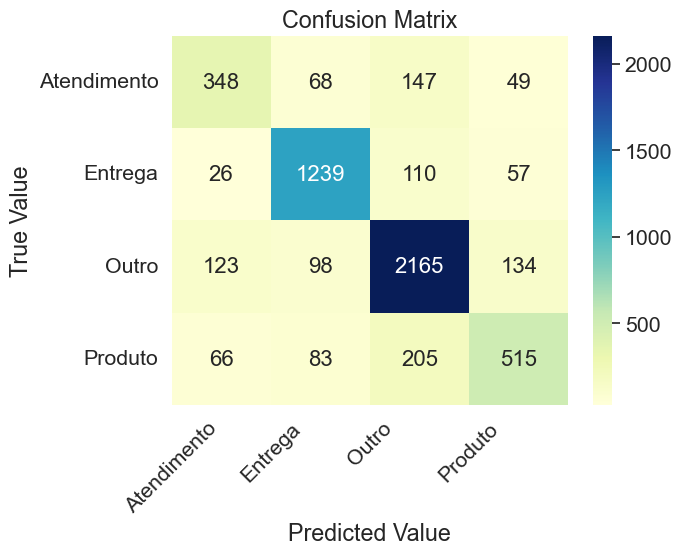

In [41]:
# Results

print("Accuracy:", accuracy_score(rounded_labels, y_hat))
print_cf(rounded_labels, y_hat)


In [42]:
print(classification_report(rounded_labels, y_hat, target_names=labels_4))

              precision    recall  f1-score   support

 Atendimento       0.62      0.57      0.59       612
     Entrega       0.83      0.87      0.85      1432
       Outro       0.82      0.86      0.84      2520
     Produto       0.68      0.59      0.63       869

    accuracy                           0.79      5433
   macro avg       0.74      0.72      0.73      5433
weighted avg       0.78      0.79      0.78      5433



In [43]:
# LSTM
model = Sequential()
model.add(Embedding(vocab_size,output_dim, input_length = maxlen, embeddings_constraint=maxnorm(3)))
model.add(LSTM(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(output_dim, kernel_constraint=maxnorm(3)))
model.add(Dense(4,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [44]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 47, 32)            370560    
                                                                 
 lstm (LSTM)                 (None, 47, 32)            8320      
                                                                 
 dropout_6 (Dropout)         (None, 47, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 47, 32)            8320      
                                                                 
 dropout_7 (Dropout)         (None, 47, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 4)                

In [45]:
model.save('lstm.h5')

In [46]:
# Creating a output directory to store the models weights

output_dir_lstm = './LSTM_outputs'
if not os.path.exists(output_dir_lstm): ### If the file directory doesn't already exists,
    os.makedirs(output_dir_lstm) ### Make it please

model_checkpoint = ModelCheckpoint(filepath=output_dir_lstm+'/weights.{epoch:02d}.hdf5',
                                  save_weights_only=True)

In [47]:
start = time.time()

# Ajustar o modelo ao conjunto de treino
lstm_hist = model.fit(X_train, y_train, epochs=10, validation_split=0.3, callbacks=[model_checkpoint])

end = time.time()

Epoch 1/10
278/278 [==============================] - 32s 83ms/step - loss: 1.0570 - accuracy: 0.5549 - val_loss: 0.8875 - val_accuracy: 0.6495
Epoch 2/10
278/278 [==============================] - 22s 79ms/step - loss: 0.7230 - accuracy: 0.7195 - val_loss: 0.6991 - val_accuracy: 0.7378
Epoch 3/10
278/278 [==============================] - 25s 89ms/step - loss: 0.5722 - accuracy: 0.7841 - val_loss: 0.6763 - val_accuracy: 0.7534
Epoch 4/10
278/278 [==============================] - 25s 89ms/step - loss: 0.4797 - accuracy: 0.8174 - val_loss: 0.6690 - val_accuracy: 0.7518
Epoch 5/10
278/278 [==============================] - 26s 94ms/step - loss: 0.4139 - accuracy: 0.8521 - val_loss: 0.8449 - val_accuracy: 0.7507
Epoch 6/10
278/278 [==============================] - 35s 126ms/step - loss: 0.3832 - accuracy: 0.8705 - val_loss: 1.0830 - val_accuracy: 0.7725
Epoch 7/10
278/278 [==============================] - 36s 130ms/step - loss: 0.3376 - accuracy: 0.8863 - val_loss: 0.7924 - val_accurac

Lowest Validation Loss: epoch 4
Highest Validation Accuracy: epoch 6
Training duration(minutes): 4.601942634582519


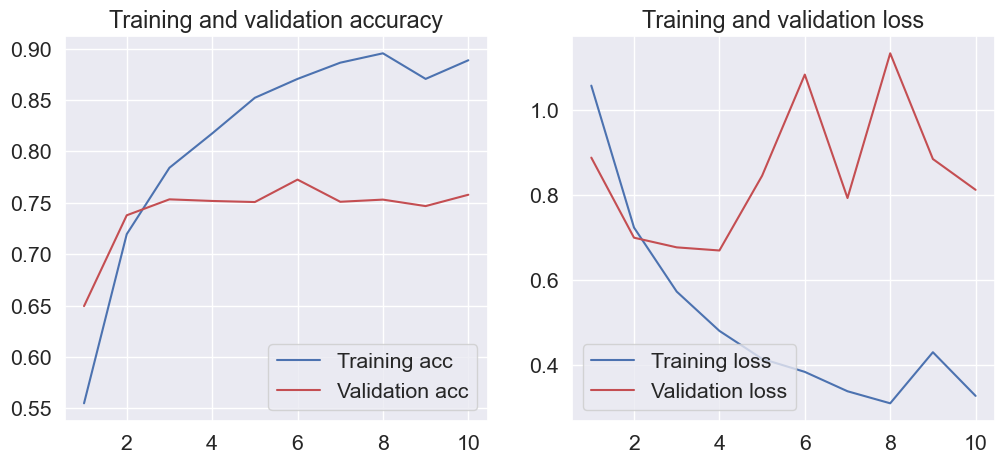

In [48]:
# LSTM Result

# Plotting the training accuracy and loss
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    print("Lowest Validation Loss: epoch {}".format(np.argmin(val_loss)+1))
    print("Highest Validation Accuracy: epoch {}".format(np.argmax(val_acc)+1))

plot_history(lstm_hist)
total = (end-start)/60
print('Training duration(minutes): {}'.format(total))

In [49]:
epoch_num_lstm = get_max_val_acc_epoch(lstm_hist)
model.load_weights(output_dir_lstm+"/weights."+epoch_num_lstm+".hdf5") # Load in model weights

In [50]:
# Making inference on the test data
y_test_probs = model.predict(X_test)

# Turn probabilities into an interger prediction
y_hat = []
for prob in y_test_probs:
    y_hat.append(np.argmax(prob))

170/170 [==============================] - 4s 18ms/step


In [51]:
# Para aplicar as métricas, preciso converter do one-hot encoded para single-digit 
rounded_labels=np.argmax(y_test, axis=1)

Accuracy: 0.7769188293760353


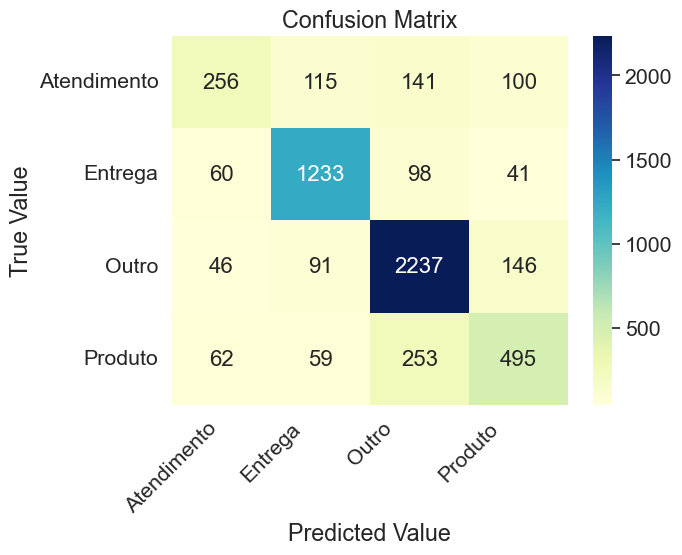

In [52]:
# Results

print("Accuracy:", accuracy_score(rounded_labels, y_hat))
print_cf(rounded_labels, y_hat)

In [53]:
print(classification_report(rounded_labels, y_hat, target_names=labels_4))

              precision    recall  f1-score   support

 Atendimento       0.60      0.42      0.49       612
     Entrega       0.82      0.86      0.84      1432
       Outro       0.82      0.89      0.85      2520
     Produto       0.63      0.57      0.60       869

    accuracy                           0.78      5433
   macro avg       0.72      0.68      0.70      5433
weighted avg       0.77      0.78      0.77      5433

